# <span style="color:#3E6BCE">1) 주제</span>

Web crawling과 random forest를 활용한 축구 분석 지표 제안

# <span style="color:#3E6BCE">2) 주제 선정 이유</span>

통계 스포츠의 대표격으로 불리는 야구가 통계를 사용하기 시작한 배경은 세이버 메트릭스의 도입과 함께 OPS(출루율 + 장타율), wOBA(가중 출루율) 등의 정교한 분석 지표가 탄생한 것에 있다. 최근, 축구에서도 통계 분석의 중요성이 인식되기 시작하며, xG(기대 득점)와 같이 특정 위치와 상황을 고려한 분석 지표가 등장하고 있다.<br><br>
하지만, xG와 같은 지표는 각도, 슈팅지역 등을 고려한 지표이기 때문에, 먼 과거부터 새로운 데이터를 수집해 지표를 만들어야 했다. 그래서 야구의 OPS와 같이 기존 지표들을 활용해 유의미한 지표를 도입한다면, 분석의 정확도를 높일 수 있을 뿐만 아니라, 새롭게 데이터를 수집해야 할 필요도 없기에 이러한 지표를 제안하는 것을 주제로 선정하게 되었다.<br><br>
그리고 proposal시 선정하였던 주제인 축구 경기 결과 예측 모델 제작은, 매년마다 리그의 팀들이 변경되기에 특정 팀들은 데이터의 양이 부족해 목표하던 정확도의 예측 모델 제작이 불가능할 것이라 판단해, 새로운 주제를 고안하게 되었다. 또한, 모델링 제작에 필요한 사이트의 해당 데이터가 크롤링이 불가능하게 되어 있어, 위와 같은 새로운 주제로 이번 프로젝트를 진행하게 되었다.

# <span style="color:#3E6BCE">3) 프로젝트 목표 및 내용</span>

### ● 프로젝트 목표
이 프로젝트는 경기 요소 중 가장 중요한 요소인 골을 target variable로 설정했을 때, 제안하고자 하는 새로운 지표의 정확도가 80% 이상인 지표를 설계하는 것을 목표로 한다.

### ● 프로젝트 설명
1. **Web crawling**<br>
selenium을 활용해 득점과 관련될 수 있는 모든 지표 데이터들을 수집하였다. 또한 이 프로젝트는 English Premier League의 데이터를 대상으로 하였으며, 20-21 시즌은 현재 진행 중이기 때문에, 19-20 시즌의 자료들을 크롤링하여 사용하였다. 그리고 크롤링은 프리미어리그 공식 홈페이지(https://www.premierleague.com/), 후스코어드닷컴(https://1xbet.whoscored.com/) 을 통해 진행하였다.<br><br>
2. **Random forest 기법을 통한 유의미한 지표 추출**<br>
위의 크롤링을 거쳐 정제된 csv파일을 통해, 골 데이터를 target variable로 설정한 후, 크롤링을 통해 수집한 각 지표들의 정확도를 출력하였다. 이 후, 출력된 결과를 통해 골과 유의미한 관계를 지닌 지표들을 추출하였다.<br><br>
3. **추출된 지표들을 기반으로 새로운 축구 분석 지표 제안**<br>
2의 과정을 통해 추출된 지표들과, 이들의 골과의 유사도와 정확도를 바탕으로, 새로운 지표 제작에 각 지표가 반영될 비율을 산정하였다. 이 후, 최종적으로 지표를 고안해 축구 분석에 활용할 것을 제안한다.<br><br>

# <span style="color:#3E6BCE">4) 프로젝트 구현 내용 설명 및 코드</span>

새로운 지표 구현에 필요한 library들을 호출한다.

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from time import sleep
from datetime import datetime
import pandas as pd
from pandas.io.html import read_html
import numpy as np
import glob
import os
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

19-20 시즌 English Premier League의 모든 경기 결과와 지표들(점유율, 패스 수, 터치 수, 슈팅 수 등)을 프리미어리그 공식 사이트를 통해 crawling하였다.

In [2]:
errors = []
season = []

#19-20시즌 경기 고유 번호 46605~46985
for id in range(46605, 46985):
    url1 = f'https://www.premierleague.com/match/{id}'
    option = Options()
    option.headless = False
    driver = webdriver.Chrome(options=option)
    driver.get(url1)
    sleep(3)
    
    # 데이터 가져오기
    try:
        #날짜 데이터
        date = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((
            By.XPATH, '//*[@id="mainContent"]/div/section[2]/div[2]/section/div[1]/div/div[1]/div[1]'))).text
        date = datetime.strptime(date, '%a %d %b %Y').strftime('%m/%d/%Y')
        
        #해당 경기 팀과 결과 데이터
        home_team = driver.find_element_by_xpath(
            '//*[@id="mainContent"]/div/section[2]/div[2]/section/div[3]/div/div/div[1]/div[1]/a[2]/span[1]').text
        away_team = driver.find_element_by_xpath(
            '//*[@id="mainContent"]/div/section[2]/div[2]/section/div[3]/div/div/div[1]/div[3]/a[2]/span[1]').text
        scores = driver.find_element_by_xpath(
            '//*[@id="mainContent"]/div/section[2]/div[2]/section/div[3]/div/div/div[1]/div[2]/div/div').text
        home_score = scores.split('-')[0]
        away_score = scores.split('-')[1]
        
        #stats 데이터 부분 클릭
        elem = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.XPATH, "//*[@id='mainContent']/div/section[2]/div[2]/div[2]/div[1]/div/div/ul/li[3]")))
        elem.click()
        sleep(3)
        
        #html에 있는 table값 가져오기
        dfs = pd.read_html(driver.page_source)
        stats = dfs[-1]

        driver.quit()
    
    #예외 처리
    except:
        driver.quit()
        errors.append(id)
        continue

    # stats 데이터 처리하기
    home_stats = {}
    away_stats = {}

    home_series = stats[home_team]
    away_series = stats[away_team]
    stats_series = stats['Unnamed: 1']

    for row in zip(home_series, stats_series, away_series):
        stat = row[1].replace(' ', '_').lower()
        home_stats[stat] = row[0]
        away_stats[stat] = row[2]

    stats_check = ['possession_%', 'shots_on_target', 'shots', 'touches', 'passes','tackles', 'clearances', 'corners', 'offsides', 'yellow_cards','red_cards', 'fouls_conceded']

    for stat in stats_check:
        if stat not in home_stats.keys():
            home_stats[stat] = 0
            away_stats[stat] = 0

    # 전체 데이터 저장하기
    match = [date, home_team, away_team, home_score, away_score, home_stats['possession_%'], away_stats['possession_%'],
             home_stats['shots_on_target'], away_stats['shots_on_target'], home_stats['shots'], away_stats['shots'],
             home_stats['touches'], away_stats['touches'], home_stats['passes'], away_stats['passes'],
             home_stats['tackles'], away_stats['tackles'], home_stats['clearances'], away_stats['clearances'],
             home_stats['corners'], away_stats['corners'], home_stats['offsides'], away_stats['offsides'],
             home_stats['yellow_cards'], away_stats['yellow_cards'], home_stats['red_cards'], away_stats['red_cards'],
             home_stats['fouls_conceded'], away_stats['fouls_conceded']]

    season.append(match)

    # 데이터 추출하기
    columns = ['date', 'home_team', 'away_team', 'home_score', 'away_score']

    for stat in stats_check:
        columns.append(f'home_{stat}')
        columns.append(f'away_{stat}')

    dataset = pd.DataFrame(season, columns=columns)
    dataset.to_csv('C:/Users/ballj/OneDrive/바탕 화면/Premierleague_19_20.csv', index=False)

Crawling을 진행한 데이터는 경기별 홈팀, 원정팀으로 나눠져있는 데이터였기에 이를 각 팀 별 데이터로 나타내질 수 있도록 변경하였다.

In [3]:
#홈/원정팀 데이터를 열을 나누어 각 팀 별 데이터로 변경하여 csv 파일 저장
premier = pd.read_csv('C:/Users/ballj/OneDrive/바탕 화면/Premier_league_19_20.csv', encoding = "utf-8")
premier_1 = premier
premier_1 = premier_1[["date", "home_team", "home_score", "home_possession_%", "home_shots_on_target", "home_shots", "home_touches", "home_passes",
                     "home_tackles", "home_clearances", "home_corners", "home_offsides", "home_yellow_cards", "home_red_cards",
                     "home_fouls_conceded"]]
premier_2 = premier
premier_2 = premier_2[["date", "away_team", "away_score", "away_possession_%", "away_shots_on_target", "away_shots", "away_touches", "away_passes",
                     "away_tackles", "away_clearances", "away_corners", "away_offsides", "away_yellow_cards", "away_red_cards",
                     "away_fouls_conceded"]]

premier_1 = premier_1.rename(columns={'home_team' : 'team', 'home_score' : 'score', 'home_possession_%' : 'possession_%',
       'home_shots_on_target' : 'shots_on_target', 'home_shots':'shots', 'home_touches':'touches', 'home_passes':'passes',
       'home_tackles':'tackles', 'home_clearances':'clearances', 'home_corners':'corners', 'home_offsides':'offsides',
       'home_yellow_cards':'yellow_cards', 'home_red_cards':'red_cards', 'home_fouls_conceded':'fouls_conceded'})

premier_2 = premier_2.rename(columns={'away_team' : 'team', 'away_score' : 'score', 'away_possession_%' : 'possession_%',
       'away_shots_on_target' : 'shots_on_target', 'away_shots':'shots', 'away_touches':'touches', 'away_passes':'passes',
       'away_tackles':'tackles', 'away_clearances':'clearances', 'away_corners':'corners', 'away_offsides':'offsides',
       'away_yellow_cards':'yellow_cards', 'away_red_cards':'red_cards', 'away_fouls_conceded':'fouls_conceded'})

dataCombine = pd.concat([premier_1, premier_2], axis=0)
dataCombine = pd.DataFrame(dataCombine)
dataCombine.to_csv("C:/Users/ballj/OneDrive/바탕 화면/matchdata.csv")

위의 과정까지를 통해 추출한 데이터는 19-20시즌의 모든 경기별 각 팀 데이터로, 이를 전체 시즌의 각 팀 평균 데이터로 바꾸어 추출한다.

In [4]:
team_list = dataCombine.set_index('team').index
team = []
for i in team_list:
    if i not in team:
        team.append(i)

team_summary = {}
for i in range(len(team)):
    team_summary[team[i]] = dataCombine.set_index('team').loc[team[i]].mean()

Liverpool = team_summary['Liverpool']
liv = pd.DataFrame(Liverpool)
liv = liv.transpose()

bournemouth = team_summary['AFC Bournemouth']
AFC = pd.DataFrame(bournemouth)
AFC = AFC.transpose()

bl = team_summary['Burnley']
burn = pd.DataFrame(bl)
burn = burn.transpose()

cp = team_summary['Crystal Palace']
cp = pd.DataFrame(cp)
cp = cp.transpose()

lc = team_summary['Leicester City']
lc = pd.DataFrame(lc)
lc = lc.transpose()

tot = team_summary['Tottenham Hotspur']
tot = pd.DataFrame(tot)
tot = tot.transpose()

wf = team_summary['Watford']
wf = pd.DataFrame(wf)
wf = wf.transpose()

wh = team_summary['West Ham United']
wh = pd.DataFrame(wh)
wh = wh.transpose()

mu = team_summary['Manchester United']
mu = pd.DataFrame(mu)
mu = mu.transpose()

nu = team_summary['Newcastle United']
nu = pd.DataFrame(nu)
nu = nu.transpose()

ars = team_summary['Arsenal']
ars = pd.DataFrame(ars)
ars = ars.transpose()

av = team_summary['Aston Villa']
av = pd.DataFrame(av)
av = av.transpose()

br = team_summary['Brighton and Hove Albion']
br = pd.DataFrame(br)
br = br.transpose()

ch = team_summary['Chelsea']
ch = pd.DataFrame(ch)
ch = ch.transpose()

ev = team_summary['Everton']
ev = pd.DataFrame(ev)
ev = ev.transpose()

mc = team_summary['Manchester City']
mc = pd.DataFrame(mc)
mc = mc.transpose()

nor = team_summary['Norwich City']
nor = pd.DataFrame(nor)
nor = nor.transpose()

sh = team_summary['Sheffield United']
sh = pd.DataFrame(sh)
sh = sh.transpose()

south = team_summary['Southampton']
south = pd.DataFrame(south)
south = south.transpose()

wolv = team_summary['Wolverhampton Wanderers']
wolv = pd.DataFrame(wolv)
wolv = wolv.transpose()

result = pd.concat([liv,AFC,burn,cp,lc,tot,wf,wh,mu,nu,ars,av,br,ch,ev,mc,nor,sh,south,wolv])

team = ['Liverpool','AFC Bournemouth','Burnley','Crystal Palace','Leicester City','Tottenham Hotspur','Watford',
        'West Ham United','Manchester United','Newcastle United','Arsenal','Aston Villa','Brighton and Hove Albion',
        'Chelsea','Everton','Manchester City','Norwich City','Sheffield United','Southampton','Wolverhampton Wanderers']

result['team'] = team
result = result[['team','score', 'possession_%', 'shots_on_target', 'shots', 'touches',
       'passes', 'tackles', 'clearances', 'corners', 'offsides',
       'yellow_cards', 'red_cards', 'fouls_conceded']]

result.head()

,team,score,possession_%,shots_on_target,shots,touches,passes,tackles,clearances,corners,offsides,yellow_cards,red_cards,fouls_conceded
0,Liverpool,2.236842,63.323684,6.078947,15.552632,815.447368,628.210526,14.473684,15.447368,6.763158,1.394737,1.000000,0.026316,8.710526
0,AFC Bournemouth,1.052632,43.934211,3.210526,10.236842,584.184211,386.684211,13.342105,24.368421,5.105263,1.763158,1.947368,0.078947,9.710526
0,Burnley,1.131579,41.463158,3.526316,10.184211,525.605263,337.210526,14.394737,21.921053,4.500000,2.342105,1.763158,0.000000,10.842105
0,Crystal Palace,0.815789,41.771053,3.026316,9.552632,557.815789,361.578947,17.026316,20.342105,4.368421,1.342105,1.578947,0.078947,10.657895
0,Leicester City,1.763158,56.084211,4.921053,13.815789,709.184211,510.763158,18.763158,17.894737,5.736842,1.657895,1.026316,0.078947,10.526316


In [5]:
dataframe = pd.DataFrame(result)
dataframe.to_csv("C:/Users/ballj/OneDrive/바탕 화면/final_result.csv")

위의 데이터로는 결과의 정확도가 부족할 것이라 판단되어, 골과 연관이 있을 법한 다른 지표들의 데이터를 후스코어드닷컴 사이트를 통해 추가로 추출하였다. 또한 이에 따라 추출한 데이터는 pass type 데이터와, keypass 데이터이다.

In [6]:
def passtypes(url2, sleep_time):
    #webdriver 구동
    option = Options()
    driver = webdriver.Chrome(options=option)
    driver.get(url2)
    
    #'Pass Types' 클릭
    sleep(sleep_time)
    ptypes = driver.find_element_by_link_text('Pass Types')
    ptypes.click()
    
    #데이터프레임 생성
    pt_passtypes = pd.DataFrame(columns = ['Team', 'Team 1','Cross pg', 'Through Ball pg', 'Long Balls pg', 'Short Passes pg'])
    
    #테이블에 크롤링하기
    sleep(sleep_time)
    table = driver.find_element_by_xpath('//*[@id="stage-passes"]')
    table_html= table.get_attribute('innerHTML')
    pt2 = read_html(table_html)[0]
    pt_passtypes = pd.concat([pt_passtypes, pt2], axis=0)
        
    return(pt_passtypes)

url2 = 'https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/7811/Stages/17590/TeamStatistics/England-Premier-League-2019-2020'
pt = passtypes(url2, 1)

#프리미어리그 사이트 데이터와 merge하기 위해 데이터를 정돈시키기
pt = pt.drop(['Team 1','R'], axis=1)
pt = pt.loc[[1,13,19,14,4,6,16,12,3,18,5,17,7,2,10,0,8,15,11,9], :]
pt = pt.drop([pt.columns[0]], axis=1)
pt = pt.reset_index(drop=False)
pt = pt.drop([pt.columns[0]], axis=1)
pt.head()

,Cross pg,Through Ball pg,Long Balls pg,Short Passes pg
0,24,2,66,567
1,17,1,56,337
2,20,1,73,271
3,16,1,58,334
4,21,2,55,473


In [7]:
def keypass(url3, sleep_time):
    #webdriver 구동
    option = Options()
    driver = webdriver.Chrome(options=option)
    driver.get(url3)
        
    #'detailed' 클릭
    sleep(sleep_time)
    detailed = driver.find_element_by_link_text('Detailed')
    detailed.click()
    
    #'Key passes' 클릭
    sleep(sleep_time)
    category = Select(driver.find_element_by_id('category'))
    category = category.select_by_visible_text('Key passes')
    
    #데이터프레임 생성
    key_keypass = pd.DataFrame(columns = ['Team', 'Team 1','Total', 'Long', 'Short', 'Rating'])
    
    #테이블에 크롤링하기
    sleep(sleep_time)
    table = driver.find_element_by_xpath('//*[@id="stage-team-stats-detailed"]')
    table_html= table.get_attribute('innerHTML')
    key2 = read_html(table_html)[0]
    key_keypass = pd.concat([key_keypass, key2], axis=0)
        
    return(key_keypass)

url3 = 'https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/7811/Stages/17590/TeamStatistics/England-Premier-League-2019-2020'
key = keypass(url3, 1)

#프리미어리그 사이트 데이터와 merge하기 위해 데이터를 정돈시키기
key = key.drop(['Team 1'], axis=1)
key["Team"] = key["Team"].str.replace(pat=r'[\d],[.]', repl=r"", regex=True)
key = key.loc[[1,17,7,13,2,6,18,9,4,14,10,16,15,3,12,0,19,8,11,5], :]
key = key.drop([key.columns[0]], axis=1)
key = key.reset_index(drop=False)
key = key.drop([key.columns[0]], axis=1)
key.columns = ['Total keypass', 'Long keypass', 'Short keypass', 'Rating']
key = key.drop([key.columns[3]], axis=1)
key.head()

,Total keypass,Long keypass,Short keypass
0,12.1,2.1,10.0
1,7.4,1.5,5.9
2,7.4,2.1,5.3
3,7.0,1.2,5.8
4,10.8,1.8,9.0


In [8]:
#passtype 데이터와 keypass 데이터를 합치기
passdata = pd.concat([pt,key],axis=1)
passdata.head()

,Cross pg,Through Ball pg,Long Balls pg,Short Passes pg,Total keypass,Long keypass,Short keypass
0,24,2,66,567,12.1,2.1,10.0
1,17,1,56,337,7.4,1.5,5.9
2,20,1,73,271,7.4,2.1,5.3
3,16,1,58,334,7.0,1.2,5.8
4,21,2,55,473,10.8,1.8,9.0


In [9]:
dataframe = pd.DataFrame(passdata)
dataframe.to_csv("C:/Users/ballj/OneDrive/바탕 화면/final_passdata.csv")

위의 3개의 데이터를 총합하여 최종적으로 finalstats.csv파일을 생성한다.

In [10]:
input_file = r'C:/Users/ballj/OneDrive/바탕 화면'
output_file = r'C:/Users/ballj/OneDrive/바탕 화면/finalstats.csv'

allFile_list = glob.glob(os.path.join(input_file, 'final_*'))
allData = []
for file in allFile_list:
    df = pd.read_csv(file)
    allData.append(df)
    
dataCombine = pd.concat(allData, axis=1)
dataCombine = dataCombine.drop(['Unnamed: 0','Unnamed: 0'], axis=1)
dataCombine = dataCombine.reindex(columns=['team','score', 'possession_%', 'shots_on_target','shots', 'touches', 'passes', 
                                           'tackles', 'clearances', 'corners', 'offsides', 'yellow_cards','red_cards', 'fouls_conceded',
                                           'Cross pg', 'Through Ball pg', 'Long Balls pg', 'Short Passes pg', 'Total keypass',
                                           'Long keypass', 'Short keypass'])
dataCombine.to_csv(output_file)

최종 생성된 finalstats.csv 파일을 통해 train 및 test를 진행하였다.

In [11]:
# finalstats.csv파일 중 불필요한 stats 제거 및 target variable을 int type으로 변환, int type들을 모두 float type으로 변환
data = pd.read_csv('C:/Users/ballj/OneDrive/바탕 화면/finalstats.csv',header=0)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.drop(['team'], axis = 1, inplace = True)
data = data.astype({'score':'int'})
data = data.astype({'Cross pg':'float'})
data = data.astype({'Through Ball pg':'float'})
data = data.astype({'Long Balls pg':'float'})
data = data.astype({'Short Passes pg':'float'})
data.head()

,score,possession_%,shots_on_target,shots,touches,passes,tackles,clearances,corners,offsides,yellow_cards,red_cards,fouls_conceded,Cross pg,Through Ball pg,Long Balls pg,Short Passes pg,Total keypass,Long keypass,Short keypass
0,2,63.323684,6.078947,15.552632,815.447368,628.210526,14.473684,15.447368,6.763158,1.394737,1.000000,0.026316,8.710526,24.0,2.0,66.0,567.0,12.1,2.1,10.0
1,1,43.934211,3.210526,10.236842,584.184211,386.684211,13.342105,24.368421,5.105263,1.763158,1.947368,0.078947,9.710526,17.0,1.0,56.0,337.0,7.4,1.5,5.9
2,1,41.463158,3.526316,10.184211,525.605263,337.210526,14.394737,21.921053,4.500000,2.342105,1.763158,0.000000,10.842105,20.0,1.0,73.0,271.0,7.4,2.1,5.3
3,0,41.771053,3.026316,9.552632,557.815789,361.578947,17.026316,20.342105,4.368421,1.342105,1.578947,0.078947,10.657895,16.0,1.0,58.0,334.0,7.0,1.2,5.8
4,1,56.084211,4.921053,13.815789,709.184211,510.763158,18.763158,17.894737,5.736842,1.657895,1.026316,0.078947,10.526316,21.0,2.0,55.0,473.0,10.8,1.8,9.0


In [12]:
# train 및 test
X = data.drop(['score'], axis=1)
y = data['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

Decision tree 적합 및 학습 데이터 예측을 진행하였다.

In [13]:
warnings.filterwarnings('ignore')
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [14]:
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Decision Tree 예측 정확도 : {0:.4f}'.format(accuracy))
print('\nDecisionTreeClassifier 기본 하이퍼파라미터:\n', dt_clf.get_params())

Decision Tree 예측 정확도 : 0.6667

DecisionTreeClassifier 기본 하이퍼파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


지표 모델의 정확도를 높이기 위해 하이퍼파라미터 튜닝을 진행하였다. 또한 그 결과, 기존 0.6667의 정확도에서 0.7333의 정확도로 정확도가 향상되었다.

In [15]:
params = {
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_split' : [5,10,15,20,25,30]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)
best_df_clf = grid_cv.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.7333
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 5, 'min_samples_split': 5}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    2.5s finished


# <span style="color:#3E6BCE">5) 구현 결과</span>

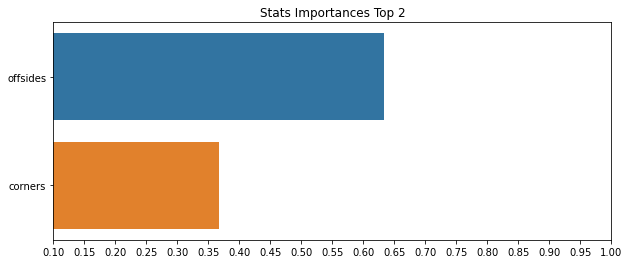

In [16]:
feature_importance_values = best_df_clf.feature_importances_
# top 중요도로 정렬하고, 시각화를 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=X_train.columns)
# 중요도값 순으로 Series 정렬
# offsides와 corners variable의 합이 0.99이상으로 다른 variable들은 무의미하다고 판단해 2개의 stat만을 선정
stats_top2 = feature_importances.sort_values(ascending=False)[:2]

plt.figure(figsize=[10, 4])
plt.title('Stats Importances Top 2')
sns.barplot(x=stats_top2, y=stats_top2.index)
plt.xlim([0.1,1])
plt.xticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
plt.show()

In [17]:
#offsides variable과 corners variable 값 확인
print(stats_top2)

offsides    0.632867
corners     0.367133
dtype: float64


##### 구현 결과, score variable에 가장 영향력 있던 두 variables는 offsides variable과 corners variable로, 이는 각각 대략 0.632, 0.367을 기록하였다.

# <span style="color:#3E6BCE">6) 결론</span>

**이 프로젝트의 최종적인 결론으로, 축구 분석에 있어 offside stat이 63% 반영되고, corner stat이 37% 반영된 ONS(Offside & Corner)지표를 제안한다.**<br>이 지표는 축구에서 가장 결정적인 지표인 골과의 연관성을 약 73% 지닌 지표로, 승부 예측 및 다양한 축구 분석에 유의미하게 활용될 수 있다.<br><br>
먼저 처음 목표하였던 80%의 정확도까지는 이 프로젝트에서 도달하지 못 하였지만, 약 73%의 정확도로 높은 수치를 기록하였다.<br>하지만 축구 분석에서 쓰일 수 있는 수 많은 지표들 중 이 프로젝트를 통해 수집하지 못 한 지표들도 있을 뿐더러, 이 프로젝트는 단순히 19-20 시즌의 프리미어리그 데이터만을 기준으로 하였기에, 보다 높은 정확도를 위해서는 더욱 다양한 자료들과 다양한 지표들을 활용해야 할 필요성이 있다. 따라서 본인은 방학 등의 기간을 통해 더욱 다양한 자료와 지표들을 축적해 더욱 더 정교한 분석 지표를 생산해 이를 여러 곳에 활용해 볼 예정이다.

# <span style="color:#3E6BCE">7) 별첨</span>

여러 데이터 crawling을 통해 최종적으로 생성한 finalstats.csv 파일을 압축 파일에 함께 첨부하였습니다. 참고 바랍니다.